In [1]:
import numpy
import matplotlib.pyplot as plt
import texplot
from glob import glob
from pprint import pprint
from os.path import join
import freealg as fa

In [2]:
# =======
# get eig
# =======

def get_eig(filename):
    data = numpy.load(filename, allow_pickle=True)['res'].item()
    eig = data['eig']
    subsize = data['subsize']
    wall_time = data['wall_time']
    return subsize, eig, wall_time


# ==========
# read files
# ==========

def read_files(dir_, filename):

    filenames = sorted(glob(join(dir_, filename)))
    pprint(filenames)
    print('')
    
    eigs = []
    subsizes = []
    wall_times = []
    for filename in filenames:
        subsize, eig, wall_time = get_eig(filename)
        subsizes.append(subsize)
        eigs.append(eig)
        wall_times.append(wall_time)
        print(f'wall_time: {wall_time/3600:>0.2f} hr')
    
    wall_times = numpy.array(wall_times)

    return subsizes, eigs, filenames

In [3]:
# ===============
# hist of log var
# ===============

def hist(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """
    
    u = eig

    if clip_x is not None:
        u = u[numpy.logical_and(u >= clip_x[0], u <= clip_x[1])]
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# ===============
# hist of log var
# ===============

def hist_of_log_var(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# =================
# hist in log scale
# =================

def hist_in_log_scale(eig, nbins, clip_x=None):
    """
    Histogram of a variable itself, but in log scale.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = 10.0**u_mid
    density = counts / lambda_
    return lambda_, density


# ============
# get all hist
# ============

def get_all_hist(subsizes, eigs, clip_x):
    
    log_xs = []
    log_rhos = []
    xs = []
    rhos = []
    print('')
    
    for subsize, eig in zip(subsizes, eigs):
        
        nbins = int(numpy.log(subsize) * 15)
        print(f'nbins: {nbins}')
        
        # x, rho = hist_in_log_scale(eig, nbins)
        # x, rho = hist(eig, nbins, clip_x=[1e-2, 1e1])
        x, rho = hist_in_log_scale(eig, nbins, clip_x=clip_x)
        xs.append(x)
        rhos.append(rho)
        
        log_x, log_rho = hist_of_log_var(eig, nbins, clip_x=clip_x)
        log_xs.append(log_x)
        log_rhos.append(log_rho)
    print('')

    return xs, rhos, log_xs, log_rhos

In [4]:
dir_ = '.'
filename = 'cifar_resnet50_fp64_l9_p*_new.npz'
clip_x = [1e-2, 1e3]

subsizes, eigs, filenames = read_files(dir_, filename)
xs, rhos, log_xs, log_rhos = get_all_hist(subsizes, eigs, clip_x)

['./cifar_resnet50_fp64_l9_p08_new.npz',
 './cifar_resnet50_fp64_l9_p09_new.npz',
 './cifar_resnet50_fp64_l9_p10_new.npz',
 './cifar_resnet50_fp64_l9_p11_new.npz',
 './cifar_resnet50_fp64_l9_p12_new.npz',
 './cifar_resnet50_fp64_l9_p13_new.npz']

wall_time: 0.00 hr
wall_time: 0.00 hr
wall_time: 0.01 hr
wall_time: 0.05 hr
wall_time: 0.30 hr
wall_time: 2.37 hr

nbins: 116
nbins: 126
nbins: 136
nbins: 147
nbins: 157
nbins: 168



In [5]:
subsizes

[np.int64(2304),
 np.int64(4608),
 np.int64(9216),
 np.int64(18432),
 np.int64(36864),
 np.int64(73728)]

NameError: name 'lam_m' is not defined

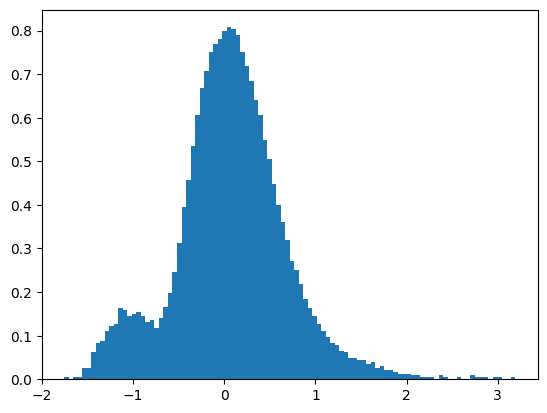

In [6]:
eig = numpy.log10(eigs[1])
h = plt.hist(eig, 100, density=True)
plt.axvline(lam_m, linestyle='--', color='gray')
plt.axvline(lam_p, linestyle='--', color='gray')
plt.axvline(-1.68, linestyle='--', color='firebrick')
plt.axvline(2.7, linestyle='--', color='firebrick')
plt.grid(True, axis='x')

In [7]:
print(max(eig))
print(min(eig))

3.1905590741391388
-1.7547906541245963


In [8]:
a = 0.001
lower, upper = numpy.quantile(eig, [a, 1-a])

print(lower)
print(upper)

-1.5359612460655332
2.785165004615347


In [9]:
ff = fa.FreeForm(eig, p=0.0)
lam_m = ff.lam_m
lam_p = ff.lam_p

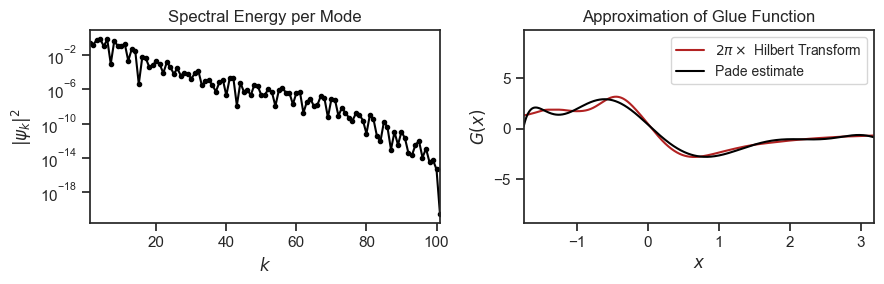

In [13]:
psi = ff.fit(method='jacobi', K=100, alpha=0, beta=0, reg=1e-1, projection='kernel',
             kernel_bw=0.05, damp='jackson', force=False, pade_p=11, pade_q=10, odd_side='left',
             pade_reg=1e-13, optimizer='de', plot=True)

In [14]:
ff._pade_sol

{'c': np.float64(-169139.13510015944),
 'D': np.float64(39885.42440227387),
 'poles': array([ 9.89949975, -7.89336136,  6.26538661, -4.27427968,  6.85091076,
         6.01920226,  5.78330099, -5.77353678, -9.73863851, -4.6152389 ]),
 'resid': array([ 3774593.93990866,  3107567.36749242,    45247.64436041,
        -1608730.85113989, -2775274.56840172,  2620756.10295539,
        -1260600.13253831, -5629779.74419829,  4776885.76534681,
         3864140.70198171]),
 'outer_iters': 40}

Plot saved to "/home/sia/Dropbox/test/free/ntk/ntk.pdf".


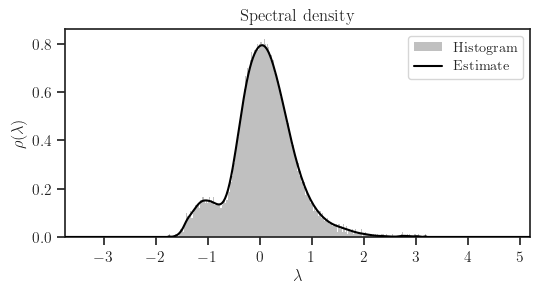

In [15]:
x = numpy.linspace(lam_m-2, lam_p+2, 300)
rho = ff.density(x, plot=True, latex=True, save='ntk.pdf')

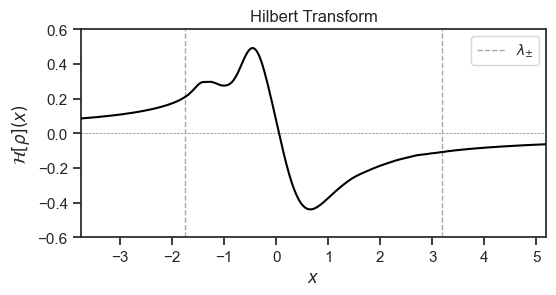

In [16]:
hilb = ff.hilbert(x, rho, plot=True)

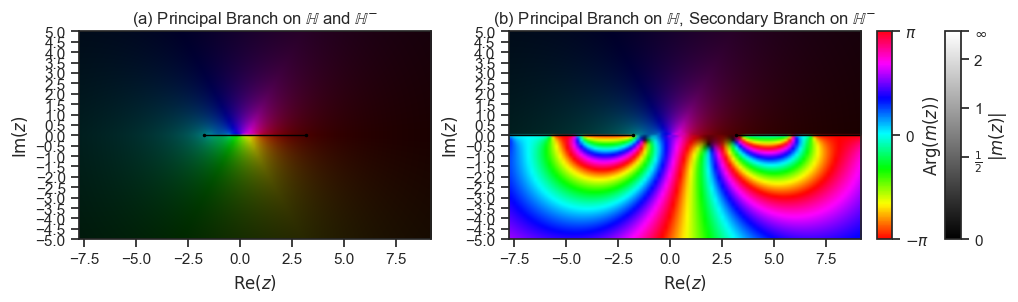

In [17]:
x = numpy.linspace(lam_m-6, lam_p+6, 100)
y = numpy.linspace(-5, 5, 100)
m1, m2 = ff.stieltjes(x, y, plot=True)

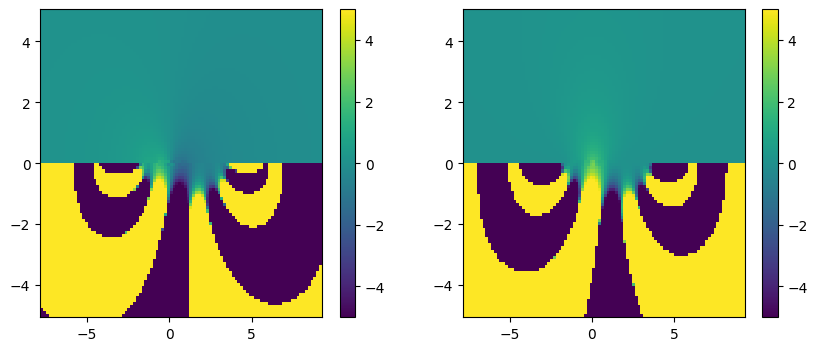

In [18]:
xx, yy = numpy.meshgrid(x, y)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
p0 = ax[0].pcolormesh(xx, yy, m2.real, vmin=-5, vmax=5)
plt.colorbar(p0)
p1 = ax[1].pcolormesh(xx, yy, m2.imag, vmin=-5, vmax=5)
plt.colorbar(p1)

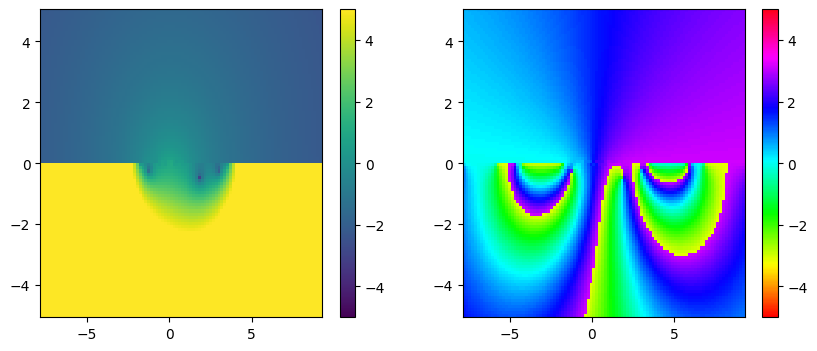

In [19]:
xx, yy = numpy.meshgrid(x, y)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
p0 = ax[0].pcolormesh(xx, yy, numpy.log(numpy.abs(m2)), vmin=-5, vmax=5)
plt.colorbar(p0)
p1 = ax[1].pcolormesh(xx, yy, numpy.angle(m2), vmin=-5, vmax=5, cmap=plt.cm.hsv)
plt.colorbar(p1)

In [32]:
import numpy
from numpy.fft import fft

# ----------------------------------------
# 1) Möbius map pair (no c_base needed)
# ----------------------------------------
def _cayley(z, lam_m, lam_p):
    """
    Map z in the lower half-plane (ℑz<0) to the unit disk |w|<1,
    sending the real cut [lam_m,lam_p] onto a nondegenerate arc.
    """
    t = (z - lam_m) / (lam_p - z)      # real z∉[lam_m,lam_p] → t∈(-∞,∞)
    return (t - 1j) / (t + 1j)         # ℑz<0 → |w|<1 (automatically)


def _inv_cayley(w, lam_m, lam_p):
    """
    Inverse map from unit disk back to the lower half-plane,
    so that w on the circle |w|=1 recovers real z on [lam_m,lam_p].
    """
    t = 1j * (1 + w) / (1 - w)         # |w|≠1 → ℑt<0; on |w|=1 gives real t
    # Solve      t = (z - lam_m)/(lam_p - z)   ⇔   z = (lam_m + t*lam_p)/(1 + t)
    return (lam_m + t * lam_p) / (1 + t)

    


# ----------------------------------------
# 2) Fit glue via Poisson / cosine series
# ----------------------------------------
def fit_glue_poisson(lam_m, lam_p, H_func,
                     n_fourier=2048, n_keep=40, ext_mode='flat'):
    """
    Construct the “glue” G(z) by solving a boundary‐value problem
    on the unit disk via the Poisson integral (cosine series).

    Returns a dict with keys:
      'a'     : array of cosine coeffs a[0..n_keep]
      'lam_m','lam_p'
      'eval'  : function to evaluate G(z) for ℑz<0
    """

    if not (lam_p > lam_m):
        raise ValueError("Require lam_p > lam_m")

    # 1) uniform angles on the circle
    theta = numpy.linspace(0, 2*numpy.pi, n_fourier, endpoint=False)

    # 2) nudge the real endpoints inwards by one step to avoid division by zero
    dx = (lam_p - lam_m) / n_fourier
    z1 = lam_m + dx
    z2 = lam_p - dx

    # 3) map those two points to angles on |w|=1
    w1  = _cayley(z1, lam_m, lam_p)
    w2  = _cayley(z2, lam_m, lam_p)
    th1 = numpy.angle(w1)
    th2 = numpy.angle(w2)

    # 4) compute positive arc length mod 2π
    arc_length = (th2 - th1) % (2 * numpy.pi)

    # 5) build mask of theta in that arc
    delta = (theta - th1) % (2 * numpy.pi)
    mask  = delta <= arc_length

    # 6) recover real support points from those arc angles
    w_pts    = numpy.exp(1j * theta[mask])
    x_on_arc = numpy.real(_inv_cayley(w_pts, lam_m, lam_p))

    # 7) sanity checks
    if x_on_arc.size == 0:
        raise RuntimeError("No arc samples: check lam_m<lam_p and n_fourier.")
    if x_on_arc.min() < lam_m or x_on_arc.max() > lam_p:
        raise RuntimeError(
            f"Mapped x_on_arc = [{x_on_arc.min():.3g}, {x_on_arc.max():.3g}] "
            f"outside [{lam_m:.3g}, {lam_p:.3g}]."
        )

    # 8) build the real boundary data g(θ)
    g      = numpy.zeros_like(theta)
    g_arc  = 2.0 * H_func(x_on_arc)
    g[mask] = g_arc
    if ext_mode == 'flat':
        g[~mask] = g_arc.mean()

    # 9) FFT → cosine coefficients a_k
    g_hat = fft(g) / n_fourier
    a     = numpy.empty(n_keep + 1, dtype=float)
    a[0]  = g_hat[0].real
    a[1:] = 2.0 * g_hat[1 : n_keep + 1].real

    # 10) evaluator via Horner in w^2
    def _eval_G(z):
        z_arr = numpy.asarray(z)
        w     = _cayley(z_arr, lam_m, lam_p)
        out   = numpy.zeros_like(w, dtype=complex)
        # evaluate a[1]*w^2 + a[2]*w^4 + ...  by Horner on w^2
        for ak in a[:0:-1]:   # reversed a[1..]
            out = ak + (w * w) * out
        return a[0] + (w * w) * out

    return {
        'a': a,
        'lam_m': lam_m,
        'lam_p': lam_p,
        'eval': _eval_G
    }


# ----------------------------------------
# 3) Evaluation helper
# ----------------------------------------
def eval_glue_poisson(z, sol):
    """
    Evaluate previously fitted Poisson-glue on any array z (ℑz<0).
    """
    return sol['eval'](z)


In [21]:
# define H on the real interval
def H_of_x(x):
    return ff.hilbert(x)

# fit the glue
glue_sol = fit_glue_poisson(lam_m, lam_p, H_of_x,
                            n_fourier=2048, n_keep=40, ext_mode='flat')

# evaluate anywhere in Im(z)<0
xgrid, ygrid = numpy.meshgrid(x, y)
zgrid = xgrid + 1j* ygrid   # ygrid < 0
G_ = eval_glue_poisson(zgrid, glue_sol)

# construct second sheet
# m2[mask_lower] = -m1[mask_lower] + Gvals


In [29]:
import numpy
from numpy.fft import fft

# ----------------------------------------
# 1) Möbius map pair (lower half-plane ↔ unit disk)
# ----------------------------------------
def _cayley(z, lam_m, lam_p):
    """
    Map ℑz<0 to |w|<1, sending [lam_m,lam_p]→arc on the circle.
    """
    t = (z - lam_m) / (lam_p - z)
    return (t + 1j) / (t - 1j)

def _inv_cayley(w, lam_m, lam_p):
    """
    Inverse: |w|<1 → ℑz<0.  On |w|=1 recovers z∈[lam_m,lam_p].
    """
    t = 1j*(w + 1)/(w - 1)
    return (lam_m + t*lam_p)/(1 + t)


# ----------------------------------------
# 2) Fit via Poisson / cosine on the disk
# ----------------------------------------
def fit_glue_poisson(lam_m, lam_p, H_func,
                     n_fourier=2048, n_keep=40, ext_mode='flat'):
    """
    Fit the “glue” G(z) so that on x∈[lam_m,lam_p], Re G=2H(x), Im G=0,
    and G is analytic and decays in ℑz<0.

    Returns a dict with keys:
      'a'     : array of n_keep+1 cos-coeffs
      'lam_m','lam_p'
      'eval'  : function G(z) for ℑz<0
    """
    if lam_p <= lam_m:
        raise ValueError("Require lam_p > lam_m")

    # 1) fixed θ grid
    theta = numpy.linspace(0, 2*numpy.pi, n_fourier, endpoint=False)

    # 2) nudge real endpoints off the cut
    dx = (lam_p - lam_m)/n_fourier
    z1, z2 = lam_m + dx, lam_p - dx

    # 3) their images on the circle
    w1 = _cayley(z1, lam_m, lam_p)
    w2 = _cayley(z2, lam_m, lam_p)
    th1 = numpy.angle(w1) % (2*numpy.pi)
    th2 = numpy.angle(w2) % (2*numpy.pi)

    # 4) find nearest‐θ indices
    i1 = int(numpy.argmin(numpy.abs(theta - th1)))
    i2 = int(numpy.argmin(numpy.abs(theta - th2)))

    # 5) carve out the arc by index
    mask = numpy.zeros(n_fourier, bool)
    if i1 <= i2:
        mask[i1:i2+1] = True
    else:
        # wrap around
        mask[i1:] = True
        mask[:i2+1] = True

    # 6) invert those w back to real x
    w_pts    = numpy.exp(1j * theta[mask])
    x_on_arc = numpy.real(_inv_cayley(w_pts, lam_m, lam_p))

    # 7) sanity checks
    if x_on_arc.size == 0:
        raise RuntimeError("No arc samples; check lam_m<lam_p.")
    if x_on_arc.min() < lam_m or x_on_arc.max() > lam_p:
        raise RuntimeError(
            f"Mapped x_on_arc=[{x_on_arc.min():.3g},{x_on_arc.max():.3g}] "
            f"outside [{lam_m:.3g},{lam_p:.3g}]."
        )

    # 8) build g(θ)
    g     = numpy.zeros_like(theta)
    g_arc = 2.0*H_func(x_on_arc)
    g[mask] = g_arc
    if ext_mode=='flat':
        g[~mask] = g_arc.mean()

    # 9) FFT → cosine coefficients
    g_hat = fft(g)/n_fourier
    a     = numpy.empty(n_keep+1, float)
    a[0]  = g_hat[0].real
    a[1:] = 2.0 * g_hat[1:n_keep+1].real

    # 10) evaluator by Horner in w^2
    def _eval_G(z):
        z_arr = numpy.asarray(z)
        w     = _cayley(z_arr, lam_m, lam_p)
        out   = numpy.zeros_like(w, complex)
        for ak in a[:0:-1]:   # reversed a[1..]
            out = ak + (w*w)*out
        return a[0] + (w*w)*out

    return {'a':a, 'lam_m':lam_m, 'lam_p':lam_p, 'eval':_eval_G}


# ----------------------------------------
# 3) Evaluator helper
# ----------------------------------------
def eval_glue_poisson(z, sol):
    """
    z : array of complex points with Im(z)<0
    sol : dict from fit_glue_poisson
    """
    return sol['eval'](z)


In [22]:
import numpy
from numpy.fft import fft

# ----------------------------------------
# 1) Möbius map pair (lower half-plane ↔ unit disk)
# ----------------------------------------
def _cayley(z, lam_m, lam_p):
    """
    Map ℑz<0 to |w|<1, sending [lam_m,lam_p]→arc on the circle.
    """
    t = (z - lam_m) / (lam_p - z)
    return (t + 1j) / (t - 1j)

def _inv_cayley(w, lam_m, lam_p):
    """
    Inverse: |w|<1 → ℑz<0.  On |w|=1 recovers z∈[lam_m,lam_p].
    """
    t = 1j*(w + 1)/(w - 1)
    return (lam_m + t*lam_p)/(1 + t)


# ----------------------------------------
# 2) Fit via Poisson / cosine on the disk
# ----------------------------------------
def fit_glue_poisson(lam_m, lam_p, H_func,
                     n_fourier=2048, n_keep=40, ext_mode='flat'):
    """
    Fit the “glue” G(z) so that on x∈[lam_m,lam_p], Re G=2H(x), Im G=0,
    and G is analytic and decays in ℑz<0.

    Returns a dict with keys:
      'a'     : array of n_keep+1 cos-coeffs
      'lam_m','lam_p'
      'eval'  : function G(z) for ℑz<0
    """
    if lam_p <= lam_m:
        raise ValueError("Require lam_p > lam_m")

    # 1) fixed θ grid
    theta = numpy.linspace(0, 2*numpy.pi, n_fourier, endpoint=False)

    # 2) nudge real endpoints off the cut
    dx = (lam_p - lam_m)/n_fourier
    z1, z2 = lam_m + dx, lam_p - dx

    # 3) their images on the circle
    w1 = _cayley(z1, lam_m, lam_p)
    w2 = _cayley(z2, lam_m, lam_p)
    th1 = numpy.angle(w1) % (2*numpy.pi)
    th2 = numpy.angle(w2) % (2*numpy.pi)

    # 4) find nearest‐θ indices
    i1 = int(numpy.argmin(numpy.abs(theta - th1)))
    i2 = int(numpy.argmin(numpy.abs(theta - th2)))

    # 5) carve out the arc by index
    mask = numpy.zeros(n_fourier, bool)
    if i1 <= i2:
        mask[i1:i2+1] = True
    else:
        # wrap around
        mask[i1:] = True
        mask[:i2+1] = True

    # 6) invert those w back to real x
    w_pts    = numpy.exp(1j * theta[mask])
    x_on_arc = numpy.real(_inv_cayley(w_pts, lam_m, lam_p))

    # 7) sanity checks
    if x_on_arc.size == 0:
        raise RuntimeError("No arc samples; check lam_m<lam_p.")
    if x_on_arc.min() < lam_m or x_on_arc.max() > lam_p:
        raise RuntimeError(
            f"Mapped x_on_arc=[{x_on_arc.min():.3g},{x_on_arc.max():.3g}] "
            f"outside [{lam_m:.3g},{lam_p:.3g}]."
        )

    # 8) build g(θ)
    g     = numpy.zeros_like(theta)
    g_arc = 2.0*H_func(x_on_arc)
    g[mask] = g_arc
    if ext_mode=='flat':
        g[~mask] = g_arc.mean()

    # 9) FFT → cosine coefficients
    g_hat = fft(g)/n_fourier
    a     = numpy.empty(n_keep+1, float)
    a[0]  = g_hat[0].real
    a[1:] = 2.0 * g_hat[1:n_keep+1].real

    # 10) evaluator by Horner in w^2
    def _eval_G(z):
        z_arr = numpy.asarray(z)
        w     = _cayley(z_arr, lam_m, lam_p)
        out   = numpy.zeros_like(w, complex)
        for ak in a[:0:-1]:   # reversed a[1..]
            out = ak + (w*w)*out
        return a[0] + (w*w)*out

    return {'a':a, 'lam_m':lam_m, 'lam_p':lam_p, 'eval':_eval_G}


# ----------------------------------------
# 3) Evaluator helper
# ----------------------------------------
def eval_glue_poisson(z, sol):
    """
    z : array of complex points with Im(z)<0
    sol : dict from fit_glue_poisson
    """
    return sol['eval'](z)


In [37]:
import numpy
from numpy.fft import fft

# ----------------------------------------
# 1) Möbius map pair (no c_base needed)
# ----------------------------------------
def _cayley(z, lam_m, lam_p):
    """
    Map z in the lower half-plane (ℑz<0) to the unit disk |w|<1,
    sending the real cut [lam_m,lam_p] onto a nondegenerate arc.
    """
    t = (z - lam_m) / (lam_p - z)      # real z∉[lam_m,lam_p] → t∈(-∞,∞)
    return (t - 1j) / (t + 1j)         # ℑz<0 → |w|<1 (automatically)


def _inv_cayley(w, lam_m, lam_p):
    """
    Inverse map from unit disk back to the lower half-plane,
    so that w on the circle |w|=1 recovers real z on [lam_m,lam_p].
    """
    t = 1j * (1 + w) / (1 - w)         # |w|≠1 → ℑt<0; on |w|=1 gives real t
    # Solve      t = (z - lam_m)/(lam_p - z)   ⇔   z = (lam_m + t*lam_p)/(1 + t)
    return (lam_m + t * lam_p) / (1 + t)

    


# ----------------------------------------
# 2) Fit glue via Poisson / cosine series
# ----------------------------------------
def fit_glue_poisson(lam_m, lam_p, H_func,
                     n_fourier=2048, n_keep=40, ext_mode='flat'):
    """
    Construct the “glue” G(z) by solving a boundary‐value problem
    on the unit disk via the Poisson integral (cosine series).

    Returns a dict with keys:
      'a'     : array of cosine coeffs a[0..n_keep]
      'lam_m','lam_p'
      'eval'  : function to evaluate G(z) for ℑz<0
    """

    if not (lam_p > lam_m):
        raise ValueError("Require lam_p > lam_m")

    # 1) uniform angles on the circle
    theta = numpy.linspace(0, 2*numpy.pi, n_fourier, endpoint=False)

    # 2) nudge the real endpoints inwards by one step to avoid division by zero
    dx = (lam_p - lam_m) / n_fourier
    z1 = lam_m + dx
    z2 = lam_p - dx

    # 3) map those two points to angles on |w|=1
    w1  = _cayley(z1, lam_m, lam_p)
    w2  = _cayley(z2, lam_m, lam_p)
    th1 = numpy.angle(w1)
    th2 = numpy.angle(w2)

    # 4) compute positive arc length mod 2π
    arc_length = (th2 - th1) % (2 * numpy.pi)

    # 5) build mask of theta in that arc
    delta = (theta - th1) % (2 * numpy.pi)
    mask  = delta <= arc_length

    # 6) recover real support points from those arc angles
    w_pts    = numpy.exp(1j * theta[mask])
    x_on_arc = numpy.real(_inv_cayley(w_pts, lam_m, lam_p))

    # 7) sanity checks
    if x_on_arc.size == 0:
        raise RuntimeError("No arc samples: check lam_m<lam_p and n_fourier.")
    if x_on_arc.min() < lam_m or x_on_arc.max() > lam_p:
        raise RuntimeError(
            f"Mapped x_on_arc = [{x_on_arc.min():.3g}, {x_on_arc.max():.3g}] "
            f"outside [{lam_m:.3g}, {lam_p:.3g}]."
        )

    # 8) build the real boundary data g(θ)
    g      = numpy.zeros_like(theta)
    g_arc  = 2.0 * H_func(x_on_arc)
    g[mask] = g_arc
    if ext_mode == 'flat':
        g[~mask] = g_arc.mean()

    # 9) FFT → cosine coefficients a_k
    g_hat = fft(g) / n_fourier
    a     = numpy.empty(n_keep + 1, dtype=float)
    a[0]  = g_hat[0].real
    a[1:] = 2.0 * g_hat[1 : n_keep + 1].real

    # 10) evaluator via Horner in w^2
    def _eval_G(z):
        z_arr = numpy.asarray(z)
        w     = _cayley(z_arr, lam_m, lam_p)
        out   = numpy.zeros_like(w, dtype=complex)
        # evaluate a[1]*w^2 + a[2]*w^4 + ...  by Horner on w^2
        for ak in a[:0:-1]:   # reversed a[1..]
            out = ak + (w * w) * out
        return a[0] + (w * w) * out

    return {
        'a': a,
        'lam_m': lam_m,
        'lam_p': lam_p,
        'eval': _eval_G
    }


# ----------------------------------------
# 3) Evaluation helper
# ----------------------------------------
def eval_glue_poisson(z, sol):
    """
    Evaluate previously fitted Poisson-glue on any array z (ℑz<0).
    """
    return sol['eval'](z)


In [26]:
x = numpy.linspace(lam_m-6, lam_p+6, 300)
y = numpy.linspace(-5, 5, 300)
m1, m2 = ff.stieltjes(x, y, plot=False)

In [43]:
# define H on the real interval
def H_of_x(x):
    return ff.hilbert(x)

# fit the glue
glue_sol = fit_glue_poisson(lam_m, lam_p, H_of_x,
                            n_fourier=2048, n_keep=40, ext_mode='flat')

# evaluate anywhere in Im(z)<0
xgrid, ygrid = numpy.meshgrid(x, y)
zgrid = xgrid + 1j* ygrid   # ygrid < 0
G_ = eval_glue_poisson(zgrid, glue_sol)

G_ = numpy.conjugate(G_)

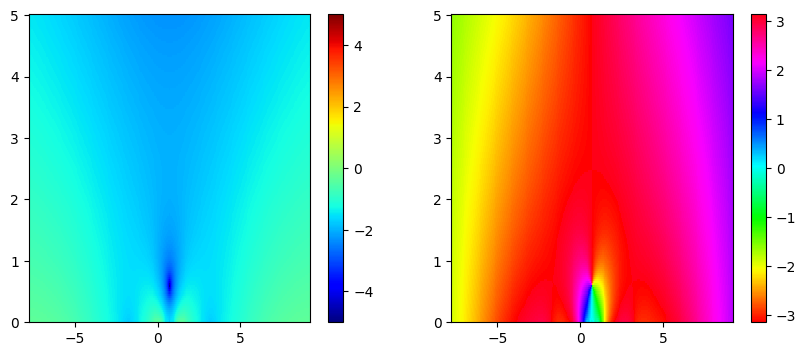

In [52]:
xx, yy = numpy.meshgrid(x, y)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
mask = y > 0
p0 = ax[0].pcolormesh(xx[mask, :], yy[mask, :], numpy.log(numpy.abs(G_[mask, :])),
                      vmin=-5, vmax=5, cmap=plt.cm.jet)
plt.colorbar(p0)
p1 = ax[1].pcolormesh(xx[mask, :], yy[mask, :], numpy.angle(G_[mask, :]),
                      vmin=-numpy.pi, vmax=numpy.pi, cmap=plt.cm.hsv)
plt.colorbar(p1)

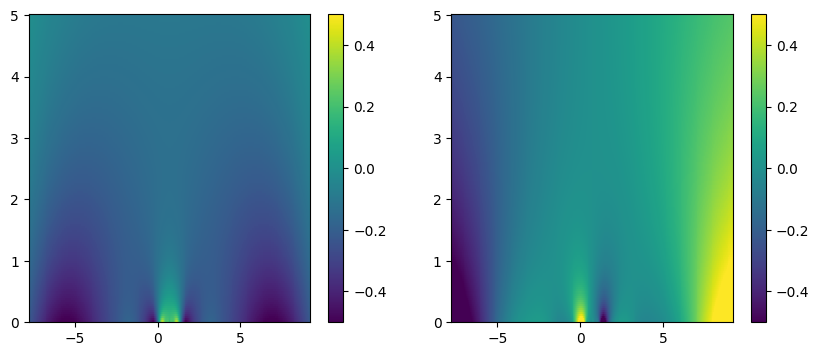

In [51]:
xx, yy = numpy.meshgrid(x, y)
mask = y > 0
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
p0 = ax[0].pcolormesh(xx[mask, :], yy[mask, :], G_[mask, :].real, vmin=-0.5, vmax=0.5)
plt.colorbar(p0)
p1 = ax[1].pcolormesh(xx[mask, :], yy[mask, :], G_[mask, :].imag, vmin=-0.5, vmax=0.5)
plt.colorbar(p1)